# Классификатор

## Подготовка датасета

Для обучения классификатора будем использовать подборку RTSD-R3, в которой представлены 106 классов различных знаков. Изображения заранее вырезаны и разбиты на две группы - для обучения и для тестирования - в отношении 3 к 1. Всего представлено 94 тысячи изображений.

Рассмотрим распределение сборок по классам:

In [9]:
import collections as cs
import pandas as pd


def get_classes_counts(*, filename, new_filename, label):
    df = pd.read_csv(filename)
    cr = cs.Counter(df[label].values)
    new_df = pd.DataFrame.from_dict(cr, orient='index').reset_index()
    new_df.columns = (label, 'count')
    new_df.to_csv(new_filename, index=False)


get_classes_counts(filename='dataset/gt_test.csv',
                   new_filename='dataset/gt_test_count.csv',
                   label='class_number')
get_classes_counts(filename='dataset/gt_train.csv',
                   new_filename='dataset/gt_train_count.csv',
                   label='class_number')

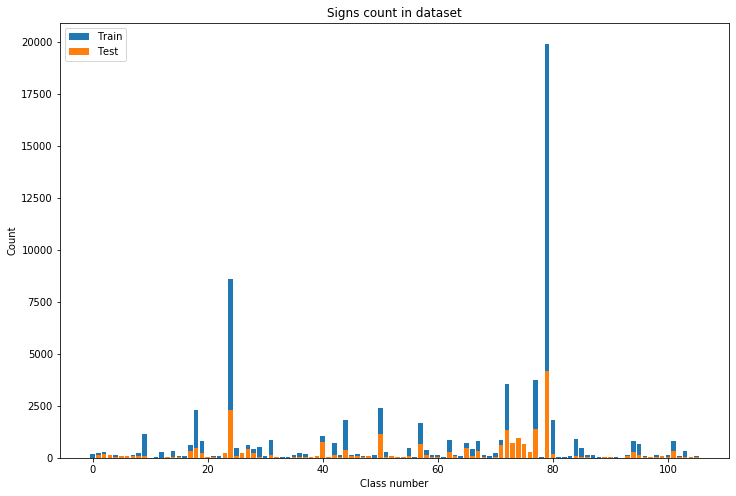

In [19]:
import matplotlib.pyplot as plt
import pandas as pd


plt.figure(figsize=(12,8))
first = pd.read_csv('dataset/gt_train_count.csv')
plt.bar(first['class_number'], height=first['count'])
second = pd.read_csv('dataset/gt_test_count.csv')
plt.bar(second['class_number'], height=second['count'])
# plt.yscale('log')
plt.legend(['Train', 'Test'], loc='upper left')
plt.xlabel('Class number')
plt.ylabel('Count')
plt.title('Signs count in dataset')
plt.savefig('results/report/test_train_dist.png')

Из приведенного выше графика видно, что данные не распределены равномерно. Более того, некоторые класы вообще не присутствуют в тестовой выборке.

Датасет придется снова собрать и уже затем случайно разбивать на выборки в заданном соотношении.
Изспользуем 2.25 : 0.75 : 1

In [23]:
import pandas as pd
import shutil as sh


def merge_csvs_and_dirs(*, files, paths_from,
                        path_to, new_filename,
                        name_label='filename',
                        pic_format='.png'):
    offset = 0
    data = []
    for file, path in zip(files, paths_from):
        df = pd.read_csv(file)
        for index, row in df.iterrows():
            new_name = str(offset + index).zfill(6) + pic_format
            sh.copyfile(path + row[name_label], path_to + new_name)
            row[name_label] = new_name
            data.append(row)
        offset = len(data)
    pd.DataFrame(data).to_csv(new_filename,  index=False)


merge_csvs_and_dirs(files=['dataset/gt_train.csv', 'dataset/gt_test.csv'],
                    paths_from=['dataset/train/', 'dataset/test/'],
                    path_to='dataset/dataset/',
                    new_filename='dataset/dataset.csv')

In [ ]:
!rm dataset/gt_train.csv
!rm dataset/gt_test.csv
!rm -r dataset/train
!rm -r dataset/test
!mkdir dataset/train
!mkdir dataset/test
!mkdir dataset/validation

In [26]:
from sklearn.model_selection import train_test_split
import pandas as pd
import shutil as sh


def split_dataframe(*, filename, f_new_filename,
                    s_new_filename, size_ratio,
                    from_label):
    df = pd.read_csv(filename)
    x = df.class_number
    y = df.drop(from_label, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=size_ratio, random_state=42
    )
    train = pd.concat([y_train, x_train], axis=1)
    train.to_csv(f_new_filename, index=False)
    test = pd.concat([y_test, x_test], axis=1)
    test.to_csv(s_new_filename, index=False)


def move_with_csv(*, filename, path_from, path_to,
                  name_label = 'filename',
                  pic_format = '.png'):
    df = pd.read_csv(filename)
    new_data = []
    for index, row in df.iterrows():
        new_name = str(index).zfill(6) + pic_format
        sh.copyfile(path_from + row[name_label], path_to + new_name)
        row[name_label] = new_name
        new_data.append(row)
    pd.DataFrame(new_data, columns=list(df.columns)).to_csv(filename, index=False)


split_dataframe(filename='dataset/dataset.csv',
                f_new_filename='dataset/train.csv',
                s_new_filename='dataset/test.csv',
                size_ratio=0.25,
                from_label='class_number')
split_dataframe(filename='dataset/train.csv',
                f_new_filename='dataset/train.csv',
                s_new_filename='dataset/validation.csv',
                size_ratio=0.25,
                from_label='class_number')
move_with_csv(filename = 'dataset/train.csv',
              path_from = 'dataset/dataset/',
              path_to = 'dataset/train/')
move_with_csv(filename = 'dataset/test.csv',
              path_from = 'dataset/dataset/',
              path_to = 'dataset/test/')
move_with_csv(filename = 'dataset/validation.csv',
              path_from = 'dataset/dataset/',
              path_to = 'dataset/validation/')

Так же для уравнивания весов классов (так как датасет очень неоднороден), понадобится csv-файл с распределением по классам.

In [38]:
get_classes_counts(filename='dataset/train.csv',
                   new_filename='dataset/classes_count.csv',
                   label='class_number')

Подготовка датасета завершена. Получили три необходимых набора: для обучения, для валидации и для тестирования.

# Обучение и обработка результатов

В результате обучения получаем log-файл, содержащий loss и accuracy, характеризующие модель на каждой эпохе обучения. В моих моделях валидационная сборка прогонялась раз в две эпохи, поэтому метрики на этом этапе в логах не присутствуют.

### Визуализация метрик во время процесса обучения

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

filename = 'results/2019-09-27_13-37-53.csv'

df = pd.read_csv(filename)
ep = list(range(df.shape[0]))
fig, axs = plt.subplots(nrows=2, figsize=(12,12))
fig.suptitle('Model report', size=22)
axs[0].plot(df['acc'])
axs[0].set_title('Model accuracy', size=16)
axs[0].grid(linewidth=1, linestyle='--')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[1].plot(df['loss'])
axs[1].set_title('Model loss', size=16)
axs[1].grid(linewidth=1, linestyle='--')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
fig.savefig('results/train_report.png')

# Классификатор А1 (106 классов, 375 эпох)
### Архитектура

<img src="results/report/A1_350.png">

```
Total params: 322,058
Trainable params: 322,058
Non-trainable params: 0
```

### Графики loss и accuracy

<img src="results/report/train_report.png">

#### 150 эпоха:
Loss на тестовом наборе: 0.1956598465714981

Accuracy на тестовом наборе: 0.9695041216443687

Prediction на 12 знаках:
```
[[9, 0.82056755], # неверно - 8
[31, 1.0],
[77, 1.0],
[44, 1.0],
[79, 1.0],
[50, 1.0],
[79, 0.8495217],  # неверно - 55
[79, 1.0],
[65, 1.0],
[103, 1.0],
[80, 1.0],
[79, 1.0]]
```
Неугаданные знаки:
<img src="results/report/000000.png" width="150" height="150">
<img src="results/report/000006.png" width="150" height="150">
Причем в первом случае знак действительно похож на знак 9:
<img src="dataset/test/000012.png" width="150" height="150">
А во втором случае знак в принципе не читаем.